In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from models.flow import FlowNet
from models.lds import LDS

import matplotlib
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

# We first define a function to load the pre-generated datasets and visualize them. 

In [16]:
def load_trajectory_data(goal_ids=[0,1,2], samples=[1000,1000,1000],
                         sub_sampling_rate=4, hist_lens=4,
                         batch_size=64):
    
    dataset = np.concatenate(
            [np.load(f'data/turn_id{goal_id}_1000.npy', allow_pickle=True)[:sample, ::sub_sampling_rate]
             for goal_id, sample in zip(goal_ids, samples)])
    
    dataset = torch.tensor(dataset, dtype=torch.float32)
    dataset = dataset.squeeze(2)
    hist, fut = dataset[:, :hist_lens], dataset[:, hist_lens:]
    
    traj_dataset = TensorDataset(hist, fut)
    traj_loader = DataLoader(traj_dataset, batch_size=batch_size, shuffle=True)
    
    return traj_dataset, traj_loader

def visualize_trajectory(traj_dataset):
    walls = [np.array([10.0, 14.0, 30.0, 14.0]),
            np.array([38.0, 14.0, 60.0, 14.0]),
            np.array([10.0, 22.0, 30.0, 22.0]),
            np.array([38.0, 22.0, 60.0, 22.0]),
            np.array([30.0,  0.0, 30.0, 14.0]),
            np.array([30.0, 22.0, 30.0, 40.0]),
            np.array([38.0,  0.0, 38.0, 14.0]),
            np.array([38.0, 22.0, 38.0, 40.0])]

    x = traj_dataset.tensors[0].reshape(-1, 2)
    y = traj_dataset.tensors[1].reshape(-1, 2)

    plt.scatter(x[:, 0], x[:, 1], alpha=0.1, color='red')
    plt.scatter(y[:, 0], y[:, 1], alpha=0.1, color='red')

# In the next cell, we visualize a balanced dataset in which there are equal numbers of trajectories going in all three directions.

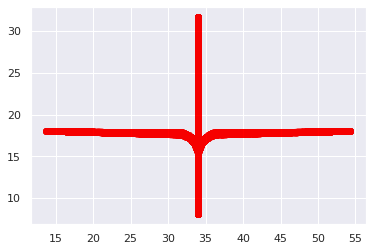

In [17]:
balanced_dataset, _ = load_trajectory_data()
visualize_trajectory(balanced_dataset)

# In the next cell, we define the training functions for the base Normalizing Flow model as well as our LDS sampling model. 

In [34]:
def train_flow(data_args, model_args, epochs=10, lr=0.01, device='cuda:1', print_epoch=False):
    
    model = FlowNet(**model_args)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    traj_dataset, traj_loader = load_trajectory_data(**data_args)
    num_batches = len(traj_loader)
    
    for epoch in range(epochs):
        loss = 0
        log_prob_loss = 0
        logabsdet_loss = 0
        
        for hist, fut in traj_loader:
            optimizer.zero_grad()
            hist = hist.to(device)
            fut = fut.to(device)
            log_prob, logabsdet = model(hist, fut)

            # Compute NLL Loss
            nll_loss = - torch.mean(log_prob - logabsdet, dim=0)
            nll_loss.backward()

            # Gradient Step
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            loss += nll_loss.item()
            log_prob_loss += log_prob.mean().item()
            logabsdet_loss += logabsdet.mean().item()
        if print_epoch:
            print(f'Epoch {epoch} NLL {(loss / num_batches):.2f} \t log_prob {(log_prob_loss / num_batches):.2f} \t logabsdet {(logabsdet_loss / num_batches):.2f}')
        
    return model, traj_loader

def train_lds(model, traj_loader, epochs=400, lr=0.001, K=3, dmax=400, dlamb=10, device='cuda:1', print_epoch=False):
    lds = LDS(K=K, future_lens=model.future_lens, hidden_size=model.hidden_size)
    lds.to(device)

    lds_optimizer = torch.optim.Adam(lds.parameters(), lr=0.001)

    hist_mu = torch.mean(traj_loader.dataset.tensors[0], axis=0).to(device)
    history_features = model.encode_history(hist_mu.unsqueeze(0).to(device))
    
    for epoch in range(epochs):
        lds_optimizer.zero_grad()
        x, _, _ = lds(history_features)
        y_hat, logabsdet = model._decoder._forward(hist_mu.unsqueeze(0).repeat_interleave(lds.K, dim=0)[:, -1],
                                             x.reshape(-1, model.future_lens , 2),
                                             history_features.repeat_interleave(lds.K, dim=0))
        # Likelihood 
        log_prob = model._decoder._base_dist.log_prob(x)
        nll_loss = -torch.mean(log_prob - logabsdet, dim=0)

        lds.y_hat = y_hat.detach()

        # Diversity
        y_hat = y_hat.reshape(-1, lds.K, model.future_lens, 2)
        y_hat_goals = y_hat[:, :, -1, :]

        diversity_loss = 0.
        for y_hat_i_goals in y_hat_goals:
            diversity_loss += (-torch.clamp(torch.min(F.pdist(y_hat_i_goals) ** 2), 0, dmax))

        lds_loss = nll_loss + dlamb*diversity_loss / y_hat.shape[0]
        lds_loss.backward(retain_graph=True)
        lds_optimizer.step()
        
        if print_epoch:
            if epoch % 10 == 0:
                print(f'Epoch {epoch} \t NLL {nll_loss.item():.2f} \t Diversity {diversity_loss.item():.2f}')
    return lds

# Finally, we define a function to plot the trajectories generated by the base flow model as well as LDS-augmented flow model. 

In [37]:
def plot_trajectories(model, lds, traj_loader, n=1000):

    walls = [np.array([10.0, 14.0, 30.0, 14.0]),
             np.array([38.0, 14.0, 60.0, 14.0]),
             np.array([10.0, 22.0, 30.0, 22.0]),
             np.array([38.0, 22.0, 60.0, 22.0]),
             np.array([30.0,  0.0, 30.0, 14.0]),
             np.array([30.0, 22.0, 30.0, 40.0]),
             np.array([38.0,  0.0, 38.0, 14.0]),
             np.array([38.0, 22.0, 38.0, 40.0])]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    color = 'grey'
    alpha = 0.3
    
    for i in range(2):
        for wall in walls:
            wall_x = [wall[0], wall[2]]
            wall_y = [wall[1], wall[3]]
            ax[i].plot(wall_x, wall_y, color='black')
        rec = matplotlib.patches.Rectangle((10.,22.), 20., 18., color=color, alpha=alpha, fill=True)
        ax[i].add_patch(rec)
        rec = matplotlib.patches.Rectangle((10.,0.), 20., 14., color=color, alpha=alpha, fill=True)
        ax[i].add_patch(rec)
        rec = matplotlib.patches.Rectangle((38.,22.), 22., 18., color=color, alpha=alpha, fill=True)
        ax[i].add_patch(rec)
        rec = matplotlib.patches.Rectangle((38.,0.), 22., 14., color=color, alpha=alpha, fill=True)
        ax[i].add_patch(rec)
        
        ax[i].set_xlim((10, 60))
        ax[i].set_ylim((0, 40))

    hist_mu = torch.mean(traj_loader.dataset.tensors[0], axis=0)
    
    with torch.no_grad():
        sampled_trajs = model.predict_n(hist_mu.repeat(1, 1, 1).to('cuda:1'), n)
        sampled_trajs = sampled_trajs.cpu().detach()
            
    sampled_trajs = sampled_trajs.reshape(-1, 2)
    ax[0].scatter(sampled_trajs[:, 0], sampled_trajs[:, 1], alpha=0.3, color='red')
    ax[0].set_title('1000 NF Predictions', fontsize=20)

    lds_y_hat = lds.y_hat.reshape(-1,2).cpu()
    ax[1].scatter(lds_y_hat[:,0], lds_y_hat[:,1], alpha=0.3, color='blue')
    ax[1].set_title('3 LDS Predictions', fontsize=20)
    return fig 

# Now, we create an imbalanced dataset and train flow and DSF models. Then, we visualize their trajectories. As shown, using just 3 samples, LDS is able to cover all modes presented in the imbalanced dataset, while the NF model is only able to generate data drawn from the major mode.

/home/jason/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


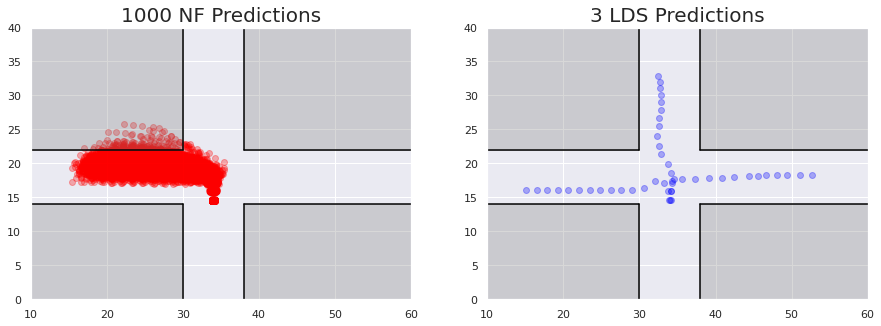

In [38]:
data_args = {
    'hist_lens': 4,
    'batch_size': 64,
    'samples': [100, 100, 1000]
}

model_args = {
    'future_lens': 16,
    'hidden_size': 32,
    'output_sizes': [32, 4]
}

train_args = {
    'epochs': 10,
    'lr': 0.01,
    'device': 'cuda:1'
}

lds_args = {
    'epochs': 400,
    'lr': 0.001,
    'dlamb': 0.8, 
    'dmax': 400
}

model, traj_loader = train_flow(data_args, model_args, **train_args)
lds = train_lds(model, traj_loader, **lds_args)
fig = plot_trajectories(model, lds, traj_loader)
